In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
E = [100, 100, 100] # suppliers capacity
D = [20, 20] # plants capacity
W = [20, 20] # DCs capacity
d = [100, 100, 100] # customers capacity

In [3]:
supply = [10, 10, 10]
demand = [80, 80, 80]

In [4]:
dummy_supply = max(0, sum(demand) - sum(supply))
# dummy_demand = max(0, sum(supply) - sum(demand))

In [5]:
# suppliers-plants transportation + purchasing $
t = np.array([
    [11, 19],
    [17, 18],
    [13, 14]
])

In [6]:
# plants-DCs transportation $
a = np.array([
    [16, 14],
    [18, 15],
])

In [7]:
# DCs-customers transportation $
c = np.array([
    [15, 16, 19],
    [13, 17, 16],
    [0, 0, 0],
])

In [82]:
from itertools import permutations

In [183]:
ch = [3, 5, 2, 1, 7, 4, 6]
ch = np.random.permutation(7)
ch

array([6, 4, 1, 5, 3, 2, 0])

In [8]:
def transport(W, d, q, i, j, demand_limit=None):
    items = min(W[j], d[i])
    if demand_limit is not None: items = min(items, demand_limit[i])
    W[j] -= items
    d[i] -= items
    q[j,i] += items
#     if items > 0:
#         print(f'Assign {items} from Plant {j+1} to Customer {i+1}')
    return items
    

In [9]:
def transportation_tree(W, d, c, v, demand_limit=None, max_iter=10):
    J = len(W)
    I = len(d)
    q = np.zeros((J,I))
    
    if demand_limit is not None:
        demand_limit = (np.array(demand_limit) * np.array(d)).astype(int)
    
#     print('\nInitiating tree')
    if demand_limit is not None: # fill dummy supply first
        total_dummy = W[-1]
        to_transport = total_dummy
        num_iter = 0
        while to_transport > 0:
            for i in sorted(range(I), key=lambda x: v[x], reverse=True):
                items = transport(W, d, q, i, -1, demand_limit)
                to_transport -= items
            if num_iter >= max_iter:
                demand_limit = None # just fill partially once
            num_iter += 1
#                 print(f'{total_dummy-to_transport}/{total_dummy}')
    
#     print('Finished filling dummy')
#     print(W, d, q, v, demand_limit)
    sum_demand = sum(d)
    to_transport = sum_demand
    num_iter = 0
    while to_transport > 0:
        for i in sorted(range(I), key=lambda x: v[x], reverse=True):
            for j in sorted(range(J), key=lambda x: c[x,i]):
                items = transport(W, d, q, i, j, demand_limit)
                to_transport -= items
#                 print(f'{sum_demand-to_transport}/{sum_demand}')
        if num_iter >= max_iter:
            demand_limit = None # just fill partially once
            num_iter += 1
#     print('Finished')

    return q

In [503]:
q = transportation_tree(W[:] + [dummy_supply], demand[:], c[:], ch[-3:], 
                        demand_limit=[0.1,0.1,0.1])
f = transportation_tree(D[:], q[:-1].sum(1), a[:], ch[-3-2:-3])
b = transportation_tree(supply[:], f.sum(1), t[:], ch[-3-2-2:-3-2])

In [504]:
q

array([[ 0.,  8.,  6.],
       [ 8.,  0.,  8.],
       [72., 72., 66.]])

In [505]:
f

array([[14.,  6.],
       [ 0., 10.]])

In [506]:
b

array([[10.,  0.],
       [ 0., 10.],
       [10.,  0.]])

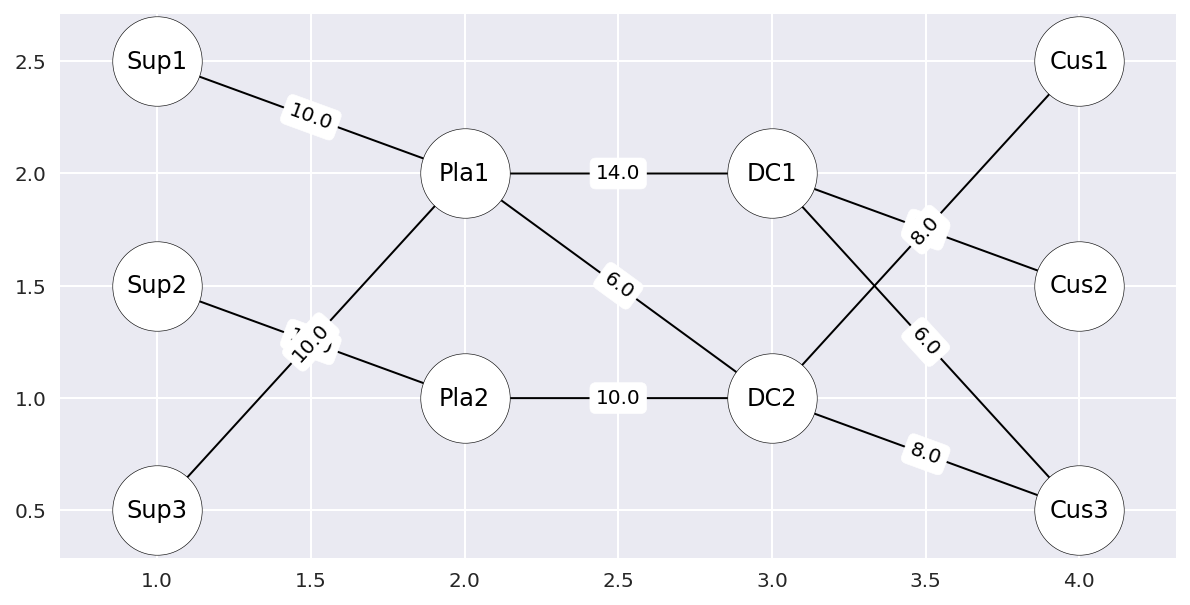

In [507]:
from utils import plot_graph
plot_graph(b, f, q[:-1])

In [10]:
def decode_chromosome(ch, E, D, W, d, t, a, c, dummy_supply, supply, demand):
    I = len(d)
    J = len(W)
    K = len(E)
#     print(ch)
    q = transportation_tree(W[:] + [dummy_supply], demand[:], c[:], 
                        ch[-2*I:-I], demand_limit=ch[-I:])
    f = transportation_tree(D[:], q[:-1].sum(1), a[:], 
                        ch[-J-2*I:-2*I])
    b = transportation_tree(supply[:], f.sum(1), t[:], 
                        ch[-K-J-2*I:-J-2*I])
    return q, f, b

In [241]:
q, f, b = decode_chromosome(list(ch) + [0.1, 0.1, 0.1], 
                                     E, D, W, d, t, a, c, dummy_supply, demand)

In [367]:
q, f, b = decode_chromosome([6.0, 1.0, 3.0, 4.0, 5.0, 2.0, 0.0, 0.7754266477209583, 0.947448101489923, 0.004218007841372051],
                            E, D, W, d, t, a, c, dummy_supply, demand)

[6.0, 1.0, 3.0, 4.0, 5.0, 2.0, 0.0, 0.7754266477209583, 0.947448101489923, 0.004218007841372051]

Initiating tree
Assign 62 from Plant 0 to Customer 1
Assign 75 from Plant 0 to Customer 2
Assign 18 from Plant 0 to Customer 1
Assign 5 from Plant 0 to Customer 2
Assign 50 from Plant 0 to Customer 3
Finished filling dummy
Assign 20 from Plant 2 to Customer 3
Assign 10 from Plant 1 to Customer 3
Finished

Initiating tree
Finished filling dummy
Assign 20 from Plant 1 to Customer 2
Assign 10.0 from Plant 2 to Customer 1
Finished

Initiating tree
Finished filling dummy
Assign 20.0 from Plant 1 to Customer 1
Assign 10.0 from Plant 3 to Customer 2
Finished


In [11]:
def evaluate_decoding(b, f, q, t, a, c):
    return np.multiply(b, t).sum() + \
           np.multiply(f, a).sum() + \
           np.multiply(q, c).sum()    

In [214]:
evaluate_decoding(b, f, q, t, a, c)

1302.0

In [12]:
def fairness(q):
    return sum([x**2 for x in q.sum(0)])

In [26]:
def chromosome_fitness(ch, E, D, W, d, t, a, c, dummy_supply, supply, demand):
    q, f, b = decode_chromosome(ch, E, D, W, d, t, a, c, dummy_supply, supply, demand)
    transp_cost = evaluate_decoding(b, f, q, t, a, c)
    fairness_cost = fairness(q[:-1])
    return (transp_cost, fairness_cost)

In [27]:
ch = [6, 4, 1, 5, 3, 2, 0] + [0.1, 0.1, 0.1]

In [245]:
chromosome_fitness(ch, E, D, W, d, t, a, c, dummy_supply, supply, demand)

1626.0

In [29]:
chromosome_fitness(ch, E, D, W, d, t, a, c, dummy_supply, supply, demand)

(1362.0, 324.0)

## Genetic Algorithm

In [98]:
import random
from deap import creator, base, tools, algorithms

In [99]:
del creator.FitnessMin
del creator.Individual

In [100]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,-1.0))
creator.create('Individual', list, fitness=creator.FitnessMin)

In [101]:
N_NODES = 2 * len(d) + len(W) + len(D) 

In [102]:
def create_chromosome(permutation_size, demand_size):
    perm = np.random.permutation(permutation_size).astype(int)
    demand = np.random.uniform(size=demand_size)
    return list(perm) + list(demand)

In [103]:
toolbox = base.Toolbox()
toolbox.register('chromosome', create_chromosome, 
                permutation_size=len(d) + len(W) + len(D), 
                demand_size=len(d))
toolbox.register('individual', tools.initIterate, creator.Individual,
                toolbox.chromosome)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [104]:
from functools import partial
ga_fitness = lambda x: partial(chromosome_fitness, E=E, 
                            D=D, W=W, d=d, t=t, a=a, c=c,
                            dummy_supply=dummy_supply, 
                            supply=supply,
                            demand=demand)(x)

In [105]:
def custom_crossover(ind1, ind2, permutation_size):
    perm1 = ind1[:permutation_size]
    perm2 = ind2[:permutation_size]
    demand1 = ind1[permutation_size:]
    demand2 = ind2[permutation_size:]
    perm_child1, perm_child2 = tools.cxPartialyMatched(perm1, perm2)
    demand_child1, demand_child2 = tools.cxSimulatedBinaryBounded(
                                        demand1, demand2, 20, 0, 1)
    child1 = list(perm_child1) + list(demand_child1)
    child2 = list(perm_child2) + list(demand_child2)
    for i, x in enumerate(child1):
        ind1[i] = child1[i]
        ind2[i] = child2[i]
    return ind1, ind2

In [106]:
def custom_mutation(ind, permutation_size):
    perm = ind[:permutation_size]
    demand = ind[permutation_size:]
    perm_mut = tools.mutShuffleIndexes(perm, 2.0/len(perm))
    demand_mut = tools.mutPolynomialBounded(demand, 20, 0, 1, 1.0/len(demand))
    mut = list(perm_mut[0]) + list(demand_mut[0])
    for i, x in enumerate(mut):
        ind[i] = mut[i]
    return ind,

In [107]:
toolbox.register('evaluate', ga_fitness)
toolbox.register('mate', custom_crossover, 
                         permutation_size=len(d) + len(W) + len(D))
toolbox.register('mutate', custom_mutation,
                         permutation_size=len(d) + len(W) + len(D))
toolbox.register('select', tools.selNSGA2)

In [108]:
toolbox.pop_size = 30

In [109]:
import copy

In [182]:
pop = toolbox.population(n=toolbox.pop_size)
hof = tools.HallOfFame(20)
# stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register('Avg', np.mean)
# stats.register('Std', np.std)
# stats.register('Min', np.min)
# stats.register('Max', np.max)
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

In [183]:
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, 
                                     mu=toolbox.pop_size,
                                     lambda_=toolbox.pop_size,
                                     cxpb=0.5, mutpb=0.2, ngen=50, 
                    stats=stats, halloffame=hof, verbose=False)

In [184]:
def plot_fronts(fronts):
    plot_colors = sns.color_palette("Set1", n_colors=10)
    fig, ax = plt.subplots(1, figsize=(6,6))
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                     x=df.columns[0], y=df.columns[1], 
                     color=plot_colors[i % len(plot_colors)])
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$')

In [185]:
fronts = tools.emo.sortLogNondominated(pop, len(pop))

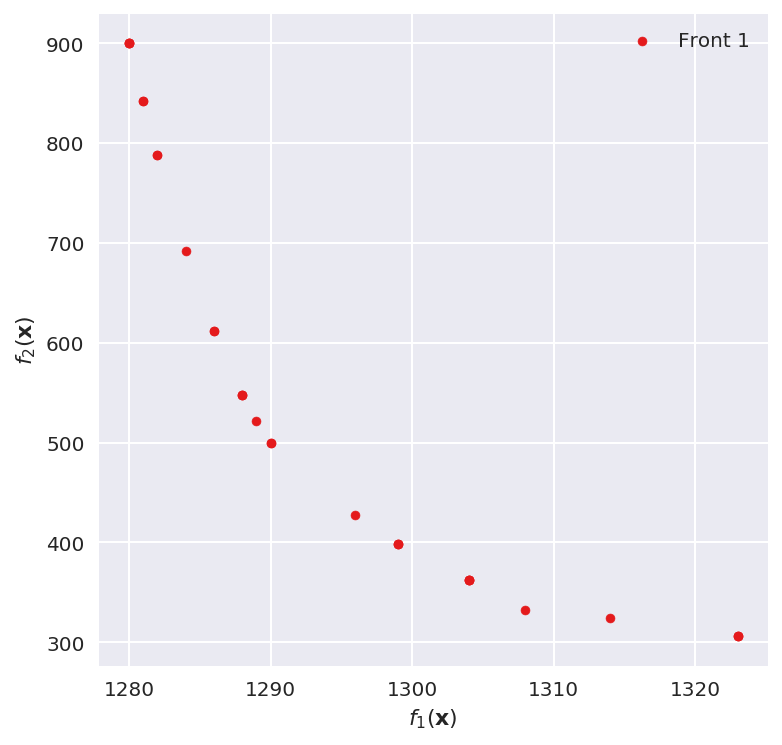

In [186]:
plot_fronts(fronts)

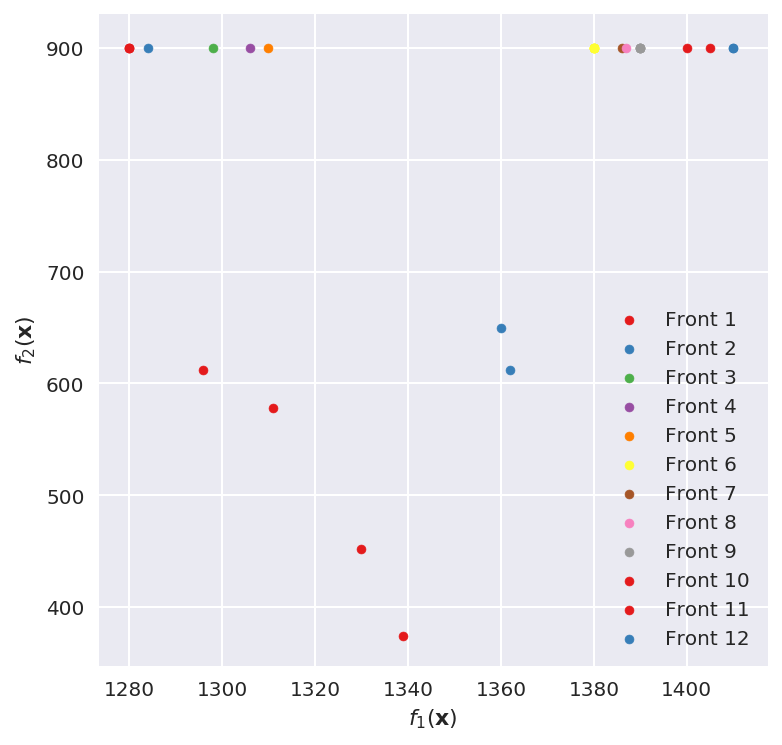

In [172]:
fronts = tools.emo.sortLogNondominated(log.select('pop')[0], 
                                       len(log.select('pop')[0]))
plot_fronts(fronts)

In [173]:
from matplotlib import animation
from IPython.display import HTML

In [174]:
def animate(frame_index, logbook):
    'Updates all plots to match frame _i_ of the animation.'
    ax.clear()    
    fronts = tools.emo.sortLogNondominated(logbook.select('pop')[frame_index], 
                                           len(logbook.select('pop')[frame_index]))
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                 x=df.columns[0], y=df.columns[1], alpha=0.47,
                 color=plot_colors[i % len(plot_colors)])
        
    ax.set_title('$t=$' + str(frame_index))
    ax.set_xlabel('$f_1(\mathbf{x})$');ax.set_ylabel('$f_2(\mathbf{x})$')
    return []

In [175]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
anim = animation.FuncAnimation(fig, lambda i: animate(i, log), 
                               frames=len(log), interval=1000, 
                               blit=True)
plt.close()

In [176]:
anim.save('animation.gif', writer='imagemagick')

In [177]:
from IPython.display import Image
Image(url='animation.gif')

In [187]:
HTML(anim.to_html5_video())

#### Max fairness

In [206]:
from utils import plot_graph

In [222]:
max_fairness = pop[min(range(len(pop)), 
                       key=lambda i: pop[i].fitness.values[1])]
max_fairness.fitness.values

(1323.0, 306.0)

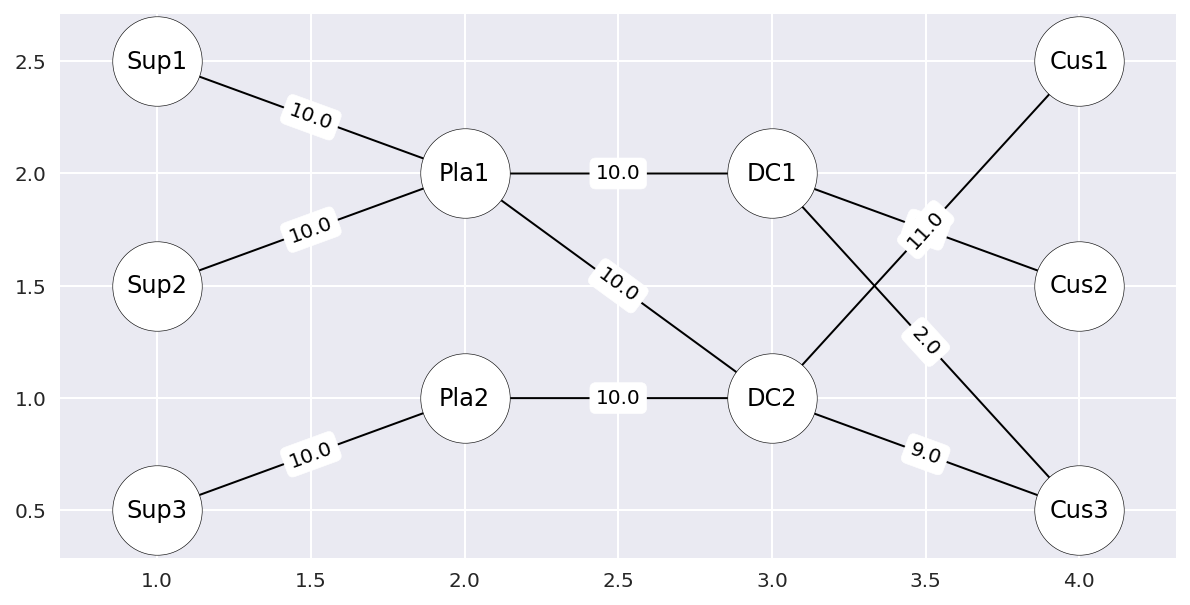

In [223]:
q, f, b = decode_chromosome(max_fairness, E, D, W, d, t, a, c, 
                            dummy_supply, supply, demand)
plot_graph(b, f, q[:-1])

In [224]:
q

array([[ 0.,  8.,  2.],
       [11.,  0.,  9.],
       [69., 72., 69.]])

#### Min cost

In [215]:
min_cost = pop[min(range(len(pop)), 
                   key=lambda i: pop[i].fitness.values[0])]
min_cost.fitness.values

(1280.0, 900.0)

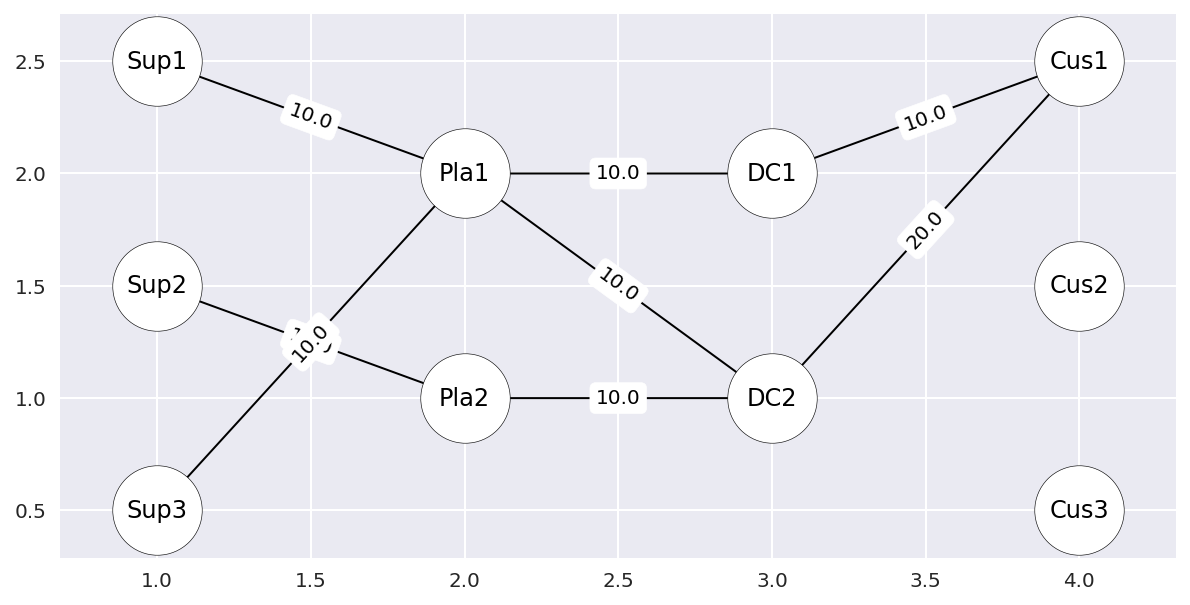

In [216]:
q, f, b = decode_chromosome(min_cost, E, D, W, d, t, a, c, 
                            dummy_supply, supply, demand)
plot_graph(b, f, q[:-1])

In [217]:
q

array([[10.,  0.,  0.],
       [20.,  0.,  0.],
       [50., 80., 80.]])

#### All solutions

In [221]:
sorted([(sum(item.fitness.values), item.fitness.values) for item in pop])

[(1629.0, (1323.0, 306.0)),
 (1629.0, (1323.0, 306.0)),
 (1629.0, (1323.0, 306.0)),
 (1638.0, (1314.0, 324.0)),
 (1640.0, (1308.0, 332.0)),
 (1666.0, (1304.0, 362.0)),
 (1666.0, (1304.0, 362.0)),
 (1666.0, (1304.0, 362.0)),
 (1666.0, (1304.0, 362.0)),
 (1697.0, (1299.0, 398.0)),
 (1697.0, (1299.0, 398.0)),
 (1697.0, (1299.0, 398.0)),
 (1724.0, (1296.0, 428.0)),
 (1790.0, (1290.0, 500.0)),
 (1790.0, (1290.0, 500.0)),
 (1811.0, (1289.0, 522.0)),
 (1836.0, (1288.0, 548.0)),
 (1836.0, (1288.0, 548.0)),
 (1836.0, (1288.0, 548.0)),
 (1898.0, (1286.0, 612.0)),
 (1898.0, (1286.0, 612.0)),
 (1976.0, (1284.0, 692.0)),
 (2070.0, (1282.0, 788.0)),
 (2070.0, (1282.0, 788.0)),
 (2123.0, (1281.0, 842.0)),
 (2123.0, (1281.0, 842.0)),
 (2180.0, (1280.0, 900.0)),
 (2180.0, (1280.0, 900.0)),
 (2180.0, (1280.0, 900.0)),
 (2180.0, (1280.0, 900.0))]

## Single Objective

In [25]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, 
                    stats=stats, halloffame=hof, verbose=True)

gen	nevals	Avg    	Std    	Min 	Max 
0  	50    	2105.28	211.646	1632	2310
1  	31    	1891.44	188.005	1629	2290
2  	31    	1878.04	234.846	1619	2290
3  	24    	1667.48	91.7715	1619	2180
4  	31    	1658.12	59.3527	1619	1904
5  	36    	1646.68	53.4567	1619	1850
6  	34    	1651.08	75.5232	1619	1974
7  	25    	1631.92	32.2465	1619	1755
8  	25    	1624.82	20.9004	1619	1755
9  	36    	1631.34	42.2789	1619	1896
10 	35    	1649.98	54.3126	1619	1790
11 	32    	1621.98	9.25957	1619	1663
12 	33    	1629.82	39.4146	1619	1893
13 	31    	1630.88	37.1105	1619	1827
14 	31    	1624.54	13.8711	1619	1698
15 	26    	1627.42	25.7729	1619	1772
16 	32    	1629.98	22.1635	1619	1738
17 	34    	1627.92	31.8382	1619	1838
18 	22    	1622.7 	9.48525	1619	1665
19 	30    	1628.56	37.5618	1619	1875
20 	30    	1628.72	34.3721	1619	1849
21 	34    	1625.1 	17.375 	1619	1721
22 	26    	1622.04	10.7069	1619	1674
23 	28    	1620.04	4.24245	1619	1646
24 	31    	1627.46	26.3842	1619	1779
25 	24    	1631.26	52.109 	1619	1986
2

In [512]:
q, f, b = decode_chromosome(hof.items[0], E, D, W, d, t, a, c, 
                            dummy_supply, supply, demand)

In [513]:
q

array([[ 0., 10.,  0.],
       [11.,  0.,  9.],
       [69., 70., 71.]])

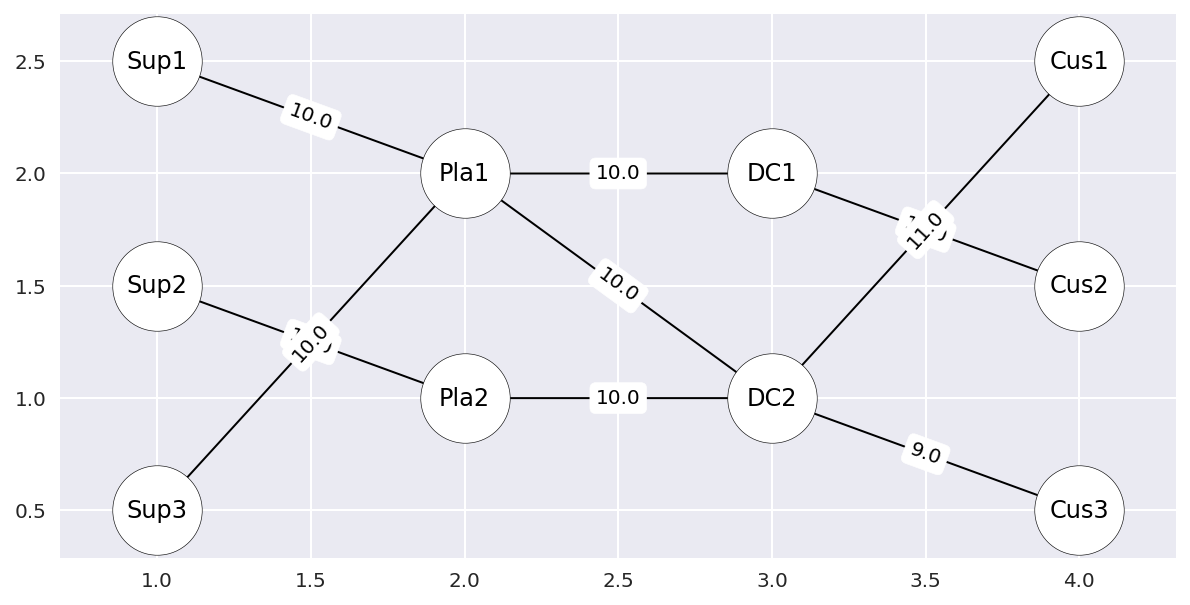

In [514]:
plot_graph(b, f, q[:-1])

In [ ]:
# mse of % of satisfaction
# no cap bottlenecks